In [ ]:
import os
import sys
sys.path.append(os.path.abspath('/home/not-naive-bayes-MIL'))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import isde
from not_naive_bayes import KernelBayesMIL
from utils import mil_contamined_gaussian

sns.set_style('whitegrid')
%matplotlib inline

### ISDE

In [11]:
X1 = np.random.randn(10000, 5)
X2 = 2 * np.random.randn(10000, 5) - 5
X = np.r_[X1, X2]

m=3000
n=2000
max_size=3
min_size=1
n_parts=10
rs=42
hs=np.logspace(-3, 0, 300)
bs=1000

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))

plt.scatter(X[:,4], X[:,1], s=3)

In [ ]:
params = {'hs':hs, 'batch_size':bs}
isde_estimator = isde.ISDE(
    grid_size=n,
    eval_size=m,
    max_block_size=max_size,
    min_block_size=min_size,
    n_partitions=n_parts,
    random_state=rs,
    **params
)
isde_estimator = isde_estimator.fit(X)

In [ ]:
isde_estimator.best_partitions_

### Contaminated Gaussians classification

In [2]:
X, Y, Z = mil_contamined_gaussian(n_bags=30, 
                                  pos_bag_rate=0.5, 
                                  n_instances_per_bag=3000, 
                                  loc_eps_sigma=1, 
                                  scale_eps_sigma=1, 
                                  seed=42
                                  )


cX = None
cZ = None
for i in range(len(X)):
    cX = X[i] if cX is None else np.r_[cX, X[i]]
    cZ = Z[i] if cZ is None else np.r_[cZ, Z[i]]

In [ ]:
hs=np.logspace(-3, 0, 300)
bs=1000
params = {'hs':hs, 'batch_size':bs}
isde_estimator = isde.ISDE(
    grid_size=2000,
    eval_size=3000,
    max_block_size=8,
    min_block_size=1,
    n_partitions=10,
    random_state=42,
    **params
)
isde_estimator = isde_estimator.fit(cX, cZ)

In [ ]:
ft_partition = [[0, 1], [2, 6], [3, 5], [4, 7]]
hs=np.logspace(-3, 0, 300)
bs=1000
params = {'hs':hs, 'batch_size':bs}

model = KernelBayesMIL(ft_partition, 
              train_grid_size=2000, 
              eval_size=3000, 
              random_state=23, 
              label_prior='unif', 
              **params
              )
model = model.fit(X, Y)

INFO:root:Fitting model for feature block 1 ...


/home/not-naive-bayes-MIL/not_naive_bayes.py:173: RuntimeWarning: divide by zero encountered in log
  ll = np.ma.masked_invalid(np.log(a) - np.log(n * (h**d) * np.power(2 * np.pi, d / 2)))
INFO:root:Fitting model for feature block 2 ...
INFO:root:Fitting model for feature block 3 ...
INFO:root:Fitting model for feature block 4 ...


In [4]:
Y_pred = model.predict(X)
float(np.mean(Y_pred == Y))

1.0

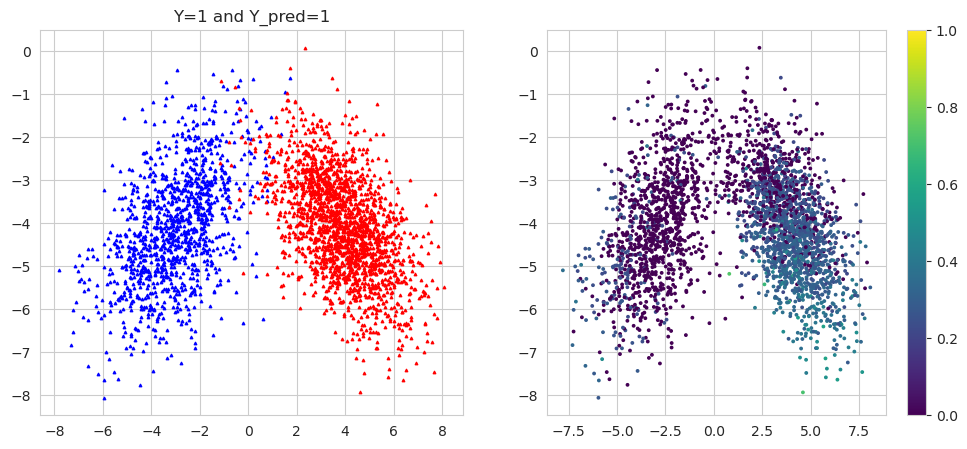

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

i = 16
X_i = X[i]
Z_i = Z[i]
# contribution with loglikelihood ratio
x_contribs = model.get_instances_contrib(X_i)
x_contribs = x_contribs if Y_pred[i]==1 else -x_contribs
c_min, c_max = x_contribs.min(), x_contribs.max()
x_contribs = (x_contribs - c_min) / (c_max - c_min)
x_contribs[x_contribs<np.quantile(x_contribs, 0.5)] = 0

# loglikelihood scores
# x_scores = model.get_instances_scores(X_i)
# x_scores = x_scores[:,1]
# c_min, c_max = x_scores.min(), x_scores.max()
# x_scores = (x_scores - c_min) / (c_max - c_min)

f1 = 2
f2 = 3
for k in range(2):
    ax[0].scatter(X_i[Z_i==k, f1], X_i[Z_i==k, f2], s=3, c='blue' if k==0 else 'red', marker='o' if Y[i]==0 else '^')
ax[0].set_title(f"Y={Y[i]} and Y_pred={Y_pred[i]}")

scatt_res = ax[1].scatter(X_i[:, f1], X_i[:, f2], s=3, c=x_contribs, cmap='viridis')
plt.colorbar(scatt_res, ax=ax[1])
